# Quantum Phase Estimation Algorithm

Translator: [unseenme](https://gitee.com/unseenme)

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/case_library/mindspore_quantum_phase_estimation.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/case_library/mindspore_quantum_phase_estimation.py)&emsp;
[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/case_library/quantum_phase_estimation.ipynb)

## Overview

Quantum Phase Estimation Algorithm, or QPE for short, is the key to many quantum algorithms. Suppose a unitary operator $U$, which acts on its eigenstate $|u\rangle$ will have a phase $e^{2\pi i \varphi}$, now we assume that the eigenvalue of the $U$ operator is unknown, that is, $\varphi$ is unknown, but the $U$ operator and the eigenstate $|u\rangle$ are known, The role of the phase estimation algorithm is to estimate this phase $\varphi$.

![quantum phase estimation](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/quantum_phase_estimation.png)

## Algorithm Analysis

The implementation of the quantum phase estimation algorithm requires two registers, the first register contains $t$ qubits initially at $|0\rangle$, the number of bits is related to the accuracy of the final phase estimation result and the success probability of the algorithm; the second register is initialized on the eigenstate $|u\rangle$ of the unitary operator $U$. The phase estimation algorithm is mainly divided into three steps:

### Step One

Perform [Hadamard](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html) gate operations on all qubits in the first register, and continuously perform `control U` gate operations on the second register, where the powers of $U$ gates are $2^0, 2^1,...,2^{t-1}$, and the control qubits are $q_{t-1}, q_{t-2},..., q_{1}, q_{0}$. Then the state in the first register will change to:

$$
|\psi_1\rangle=\frac{1}{2^{t/2}}\left(|0\rangle+e^{i2\pi 2^{t-1}\varphi}|1\rangle\right)\left(|0\rangle+e^{i2\pi2^{t-2}\varphi}|1\rangle\right)...\left(|0\rangle+e^{i2\pi 2^{0}\varphi}|1\rangle\right) = \frac{1}{2^{t/2}}\sum_{k=0}^{2^t-1}e^{i2\pi\varphi k}|k\rangle
$$

where $k$ is the decimal representation of the direct product state, for example, $k=0$ means that all t qubits in the first register are in the ground state $|00...00\rangle$, $k=2$ means $|00...10\rangle$, and so on.

### Step Two

Perform the inverse quantum Fourier transform on the first register, which is expressed as $QFT^\dagger$ in the circuit, and perform the inverse quantum Fourier transform on $|\psi_1\rangle$ to obtain

$$
|\psi_2\rangle=QFT^\dagger|\psi_1\rangle =\frac{1}{2^t}\sum_{x=0}^{2^t-1}a_x|x\rangle
$$

where

$$
a_x=\sum_{k=0}^{2^t-1}e^{2\pi i k(\varphi-x/2^t)}
$$

is the probability amplitude corresponding to the eigenbasis vector $|x\rangle$ ($x=0.1,...,2^t$).
It can be obtained from the above formula that when $2^t\varphi$ is an integer and $x=2^t\varphi$ is satisfied, the probability amplitude takes the maximum value of 1, at this time, the last state of the first register can accurately reflect $\varphi$; when $2^t\varphi$ is not an integer, $x$ is the estimate of $\varphi$, and the larger $t$, the higher the estimation accuracy.

### Step Three

Measure the qubits of the first register to obtain the final state of the first register $f=\sum_{x}^{2^t-1}a_x|x\rangle$, $x=0,1,...,2^t$, and find the maximum amplitude $a_{max}$ from it, then the $x$ in the corresponding eigenvector $|x\rangle$ divided by $2^t$ is the estimated value of phase.

## QPE Code Implementation

The following is an example to demonstrate how to implement the quantum phase estimation algorithm in MindSpore Quantum. The [T](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.TGate.html) gate is selected as the unitary operator for estimation, from the definition of

$$T|1\rangle=e^{i\pi/4}|1\rangle$$

it can be known that the phase angle to be estimated is $\varphi=\frac{1}{8}$.

Now suppose we don't know the phase information of the [T](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.TGate.html) gate, but only know that the unitary operator $U$ is a [T](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.TGate.html) gate and the eigenstate is $|1\rangle$ , then we need to use the quantum phase estimation algorithm to find its corresponding eigenvalue, that is, we need to estimate the phase angle on the eigenvalue index.

First import the relevant dependencies.

In [1]:
from mindquantum.core.gates import T, H, X, Power, BARRIER
from mindquantum.core.circuit import Circuit, UN
from mindquantum.simulator import Simulator
from mindquantum.algorithm.library import qft
import numpy as np

[UN](https://www.mindspore.cn/mindquantum/docs/en/master/core/circuit/mindquantum.core.circuit.UN.html) can specify quantum gates, target bits and control bits to build gate operations in the circuit; [Power](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.Power.html) can get the exponential form of the specified quantum gate. Because we know that the eigenstate of the [T](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.TGate.html) gate is $|1\rangle$, the second register only needs 1 bit, and the more bits in the first register, the more accurate the result, here we use 4 bits.

So we need to build a 5-bit circuit, $q_0, q_1, q_2, q_3$ bits are used for estimation, belong to the first register, and $q_4$ belong to the second register to pass in the eigenstate of the $T$ operator.

Use [UN](https://www.mindspore.cn/mindquantum/docs/en/master/core/circuit/mindquantum.core.circuit.UN.html) to perform [Hadamard](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html) gate operation on $q_0, q_1, q_2, q_3$, and use [X](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.XGate.html) gate to flip $q_4$ to obtain the eigenstate $|1\rangle$ of [T](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.TGate.html) gate.

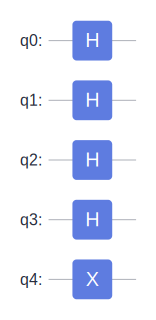

In [2]:
# pylint: disable=W0104
n = 4
circ = Circuit()
circ += UN(H, n) # Act h gate on the first 4 bits
circ += X.on(n)  # Act X gate on q4
circ.svg()

With $q_4$ as the target bit, add the control $T^{2^i}$ gate.

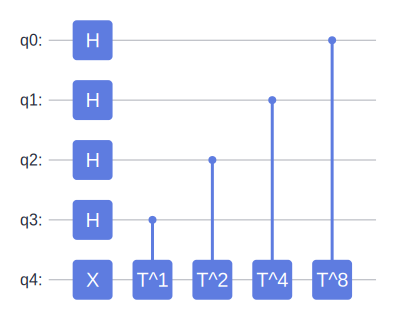

In [3]:
# pylint: disable=W0104
for i in range(n):
    circ += Power(T, 2**i).on(n, n - i - 1) # Add T^2^i gate, where q4 is the target bit and n-i-1 is the control bit
circ.svg()

Perform an inverse quantum Fourier transform on the bits in the first register.

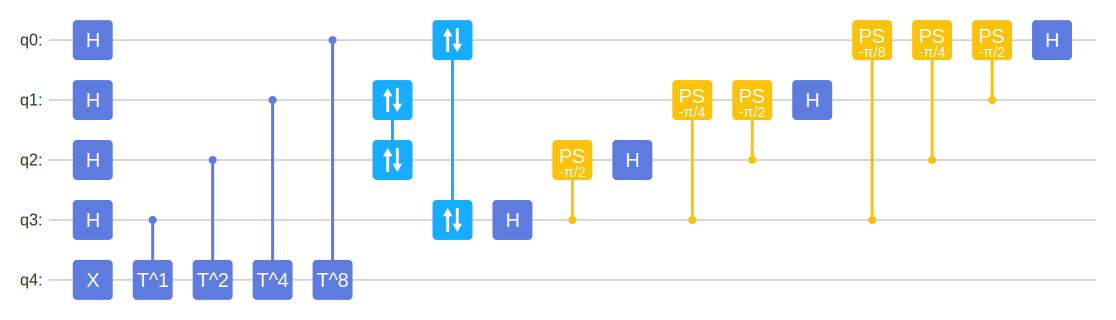

In [4]:
# pylint: disable=W0104
circ += BARRIER
circ += qft(range(n)).hermitian() # Inverse transform of quantum Fourier transform applied to the first 4 bits
circ.svg()

Select the backend, pass in the total number of bits to create a simulator, evolve the quantum circuit, and get the final state.

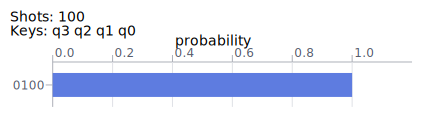

In [5]:
# pylint: disable=W0104
from mindquantum.core.gates import Measure
sim = Simulator('mqvector', circ.n_qubits)                      # Create an emulator
sim.apply_circuit(circ)                                         # Evolving the circuit with the simulator
qs = sim.get_qs()                                               # Obtain the evolved quantum state
res = sim.sampling(UN(Measure(), circ.n_qubits - 1), shots=100) # Add a measurement gate to register 1 and sample the circuit 100 times to obtain statistical results
res.svg()

It should be noted that the reading order of the measurement result as a binary string should be $|q_0q_1q_2q_3\rangle$, so we get that the measurement result of register 1 is `0010`, the probability amplitude is 1, and the final state can accurately reflect the phase $\varphi$. But `0010` is a binary result, so we convert it back to decimal and divide by $2^n$ to get our final estimate: $\varphi=\frac{2}{2^4}=\frac{1}{8}$.

We can also find out the position of the amplitude maximum $a_{max}$ in the first register by the quantum state `qs` obtained from the circuit evolution, and then obtain the corresponding eigenbasis vector $|x\rangle$, where $x$ is divided by $2^t$ to be the estimated value of the phase.

In [6]:
index = np.argmax(np.abs(qs))
print(bin(index)[2:])

10100


It should be noted that `qs` corresponds to the final state of the entire quantum circuit, so the obtained `index` also includes the bits in the second register, and the $|x\rangle$ corresponding to $a_{max}$ in the final state of the first register cannot be directly obtained, and it is necessary to convert the `index` into binary and remove the bits corresponding to $q4$, and then the $|x\rangle$ of the first register is obtained.

In [7]:
bit_string = bin(index)[2:].zfill(circ.n_qubits)[1:]        # Convert index to 01 string and remove q4
bit_string = bit_string[::-1]                               # Adjust the bit string order to q0q1q2q3
print(bit_string)

0010


Convert binary back to decimal again to get our final estimate.

In [8]:
# pylint: disable=W0104
theta_exp = int(bit_string, 2) / 2**n
theta_exp

0.125

It can be seen that the estimated phase obtained is approximately equal to $\varphi$.

In [9]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.10.1
numpy,1.23.5
System,Info
Python,3.9.16
OS,Linux x86_64
Memory,8.3 GB
CPU Max Thread,8
Date,Sun Dec 31 23:56:30 2023


## Reference

[1] Michael A. Nielsen and Isaac L. Chuang. [Quantum computation and quantum information](https://www.cambridge.org/9781107002173)